In [4]:
import numpy as np
import matplotlib.pyplot as plt
from distgen.ds_cathode_model import dowell_schmerge_pdf, dowell_schmerge_pdf_bounds, dowell_schmerge_pdf_spherical, dowell_schmerge_pdf_bounds_spherical

Text(0, 0.5, 'p$_z$ (keV/c)')

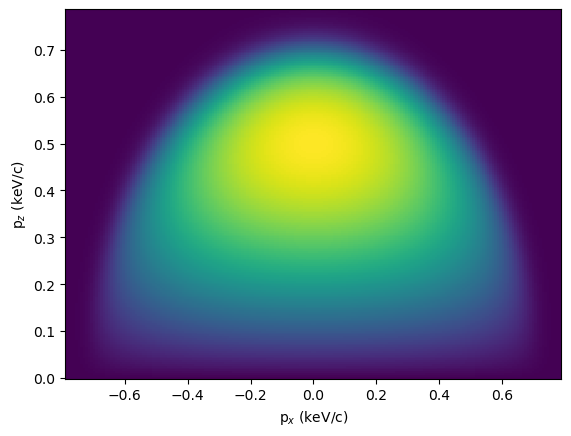

In [5]:
# Plot the projection onto px, pz
fermi_energy = 6
t = 300
photon_energy = 2.5
workfun = 2

n_points = 200
(bxm, bxp), (bym, byp), (bzm, bzp) = dowell_schmerge_pdf_bounds(photon_energy, workfun, t, fermi_energy)
px, py, pz = np.mgrid[bxm:bxp:1j*n_points, bym:byp:1j*n_points, bzm:bzp:1j*n_points]

rho = np.sum(dowell_schmerge_pdf(px, py, pz, photon_energy, workfun, t, fermi_energy), axis=1)
plt.pcolormesh(1e-3*px[:, 0, :], 1e-3*pz[:, 0, :], rho)
plt.xlabel("p$_x$ (keV/c)")
plt.ylabel('p$_z$ (keV/c)')

Text(0, 0.5, 'MTE (meV)')

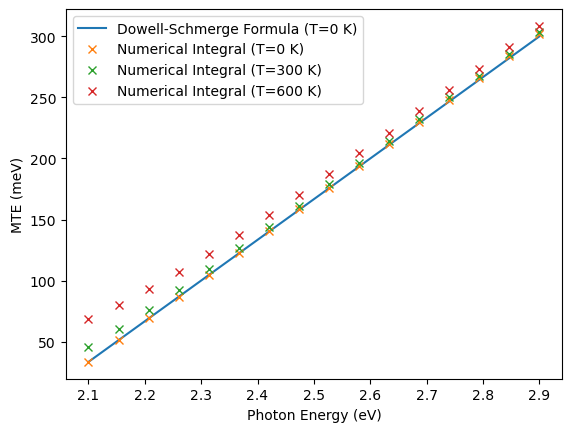

In [6]:
# Plot the MTE vs photon energy and temp
def get_mte(fermi_energy, t, photon_energy, workfun, n_points=128):
    mc2 = 511e3
    (bxm, bxp), (bym, byp), (bzm, bzp) = dowell_schmerge_pdf_bounds(photon_energy, workfun, t, fermi_energy)
    px, py, pz = np.mgrid[bxm:bxp:1j*n_points, bym:byp:1j*n_points, bzm:bzp:1j*n_points]
    rho = dowell_schmerge_pdf(px, py, pz, photon_energy, workfun, t, fermi_energy)
    norm = np.trapz(np.trapz(np.trapz(rho, dx=px[1, 0, 0] - px[0, 0, 0], axis=0), dx=py[0, 1, 0] - py[0, 0, 0], axis=0), dx=pz[0, 0, 1] - pz[0, 0, 0])
    px_sec_moment = np.trapz(np.trapz(np.trapz(px**2*rho, dx=px[1, 0, 0] - px[0, 0, 0], axis=0), dx=py[0, 1, 0] - py[0, 0, 0], axis=0), dx=pz[0, 0, 1] - pz[0, 0, 0])
    return (px_sec_moment/norm)/mc2*1e3

ephoton = np.linspace(2.1, 2.9, 16)
plt.plot(ephoton, (ephoton-2)/3*1e3, label='Dowell-Schmerge Formula (T=0 K)')

for temp in [0, 300, 600]:
    mte = np.array([get_mte(6., temp, ep, 2.) for ep in ephoton])
    plt.plot(ephoton, mte, marker='x', ls='none', label='Numerical Integral (T=%.0f K)' % temp)
plt.legend()
plt.xlabel('Photon Energy (eV)')
plt.ylabel('MTE (meV)')

(200, 400) (200, 400) (200, 400)
[0.         0.00789345 0.0157869  0.02368035 0.0315738  0.03946724
 0.04736069 0.05525414 0.06314759 0.07104104 0.07893449 0.08682794
 0.09472139 0.10261484 0.11050828 0.11840173 0.12629518 0.13418863
 0.14208208 0.14997553 0.15786898 0.16576243 0.17365588 0.18154932
 0.18944277 0.19733622 0.20522967 0.21312312 0.22101657 0.22891002
 0.23680347 0.24469692 0.25259036 0.26048381 0.26837726 0.27627071
 0.28416416 0.29205761 0.29995106 0.30784451 0.31573796 0.3236314
 0.33152485 0.3394183  0.34731175 0.3552052  0.36309865 0.3709921
 0.37888555 0.386779   0.39467244 0.40256589 0.41045934 0.41835279
 0.42624624 0.43413969 0.44203314 0.44992659 0.45782003 0.46571348
 0.47360693 0.48150038 0.48939383 0.49728728 0.50518073 0.51307418
 0.52096763 0.52886107 0.53675452 0.54464797 0.55254142 0.56043487
 0.56832832 0.57622177 0.58411522 0.59200867 0.59990211 0.60779556
 0.61568901 0.62358246 0.63147591 0.63936936 0.64726281 0.65515626
 0.66304971 0.67094315 0.678836

Text(0, 0.5, 'p$_\\theta$ (radian)')

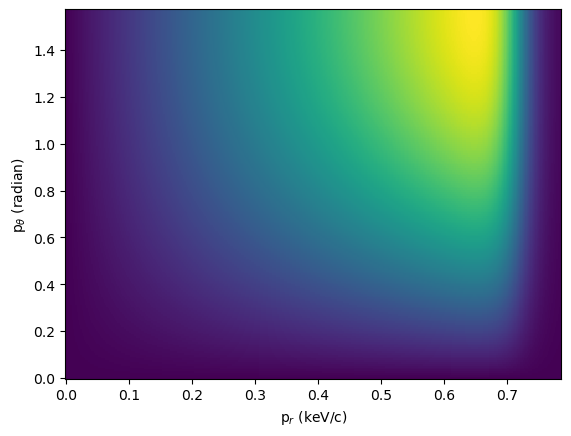

In [14]:
# Demonstrate getting data in spherical coords for integration
(rl, ru), (tl, tu) = dowell_schmerge_pdf_bounds_spherical(photon_energy, workfun, t, fermi_energy)

pt, pr = np.mgrid[tl:tu:1j*n_points, rl:ru:1j*2*n_points]
rho = dowell_schmerge_pdf_spherical(pr, pt, photon_energy, workfun, t, fermi_energy)

print(pt.shape, pr.shape, rho.shape)

print(pt[:,-1])

plt.pcolormesh(1e-3*pr, pt, rho)
plt.xlabel("p$_r$ (keV/c)")
plt.ylabel(r'p$_\theta$ (radian)')